<a href="https://colab.research.google.com/github/Sergius-DS/A_B_TESTING/blob/main/checkout_AB_TEST_2variants_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pingouin
import pingouin

In [ ]:
import warnings
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from scipy import stats
from scipy.stats import chisquare

from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats import power
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# EXPLORATORY DATA ANALYSIS

In [ ]:
checkout = pd.read_csv('checkout.csv')

In [ ]:
checkout.head()

,Unnamed: 0,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,0,877621,A,29.410131,1.0,F,chrome,66.168628
1,1,876599,A,NaN,0.0,M,firefox,49.801887
2,2,905407,A,27.446845,1.0,M,chrome,56.744856
3,3,883562,A,30.602233,1.0,M,safari,71.890718
4,4,840542,A,29.668895,1.0,F,safari,67.410696


In [ ]:
checkout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     9000 non-null   int64  
 1   user_id        9000 non-null   int64  
 2   checkout_page  9000 non-null   object 
 3   order_value    7605 non-null   float64
 4   purchased      9000 non-null   float64
 5   gender         9000 non-null   object 
 6   browser        9000 non-null   object 
 7   time_on_page   9000 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 562.6+ KB


**OBSERVATIONS:**

NaN values represent missing data, which typically means that the user did not place an order. Filling the NaN values in the order_value column with zeros would alter the mean of the column, as well as other statistical properties.

TO DROP IRRELEVANT COLUMN

In [ ]:
checkout = checkout.drop('Unnamed: 0', axis=1)

In [ ]:
checkout.head()

,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,877621,A,29.410131,1.0,F,chrome,66.168628
1,876599,A,NaN,0.0,M,firefox,49.801887
2,905407,A,27.446845,1.0,M,chrome,56.744856
3,883562,A,30.602233,1.0,M,safari,71.890718
4,840542,A,29.668895,1.0,F,safari,67.410696


In [ ]:
checkout['gender'].value_counts(normalize=True)

,proportion
gender,
F,0.507556
M,0.492444


TAKING A SAMPLE TO CHECK PROPORTIONS

In [ ]:
sample_df = checkout.sample(3000)
sample_df['gender'].value_counts(normalize=True)

,proportion
gender,
F,0.505667
M,0.494333


In [ ]:
checkout.groupby('checkout_page')['gender'].value_counts(normalize=True)

checkout_page  gender
A              M         0.505000
               F         0.495000
B              F         0.507333
               M         0.492667
C              F         0.520333
               M         0.479667
Name: proportion, dtype: float64

In [ ]:
print(checkout.groupby('checkout_page')['time_on_page'].mean())

checkout_page
A    44.668527
B    42.723772
C    42.223772
Name: time_on_page, dtype: float64


CHECKING DISTRIBUTION BALANCE IN BROWSERS

In [ ]:
checkout.groupby('checkout_page')['browser'].value_counts(normalize=True)

checkout_page  browser
A              chrome     0.341333
               safari     0.332000
               firefox    0.326667
B              safari     0.352000
               firefox    0.325000
               chrome     0.323000
C              safari     0.346000
               chrome     0.330000
               firefox    0.324000
Name: proportion, dtype: float64

CHECK FOR DUPLICATES

In [ ]:
print(len(checkout))
print(len(checkout.drop_duplicates(keep='first')))

9000
9000


In [ ]:
# Unique users in group B
print(checkout[checkout['checkout_page'] == 'B']['user_id'].nunique())

2938


In [ ]:
# Unique users who purchased at least once
print(checkout[checkout['checkout_page'] == 'B']\
      .groupby('user_id')['purchased'].max().sum())

2491.0


In [ ]:
# Total purchase events in group B
print(checkout[checkout['checkout_page'] == 'B']['purchased'].sum())

2541.0


In [ ]:
print(checkout.groupby('checkout_page')['order_value'].agg({'mean', 'std', 'count'}))

                    std  count       mean
checkout_page                            
A              2.418837   2461  24.956437
B              7.277644   2541  29.876202
C              4.869816   2603  34.917589


**OBSERVATIONS:**

Variant C has the highest mean order value 35 dollars

B has the highest spread 7 dollars

A has the lowest number of purchasers

In [ ]:
checkout.groupby('gender')['purchased'].mean()

,purchased
gender,
F,0.908056
M,0.780009


In [ ]:
checkout[(checkout['browser'] == 'chrome') | (checkout['browser'] == 'safari')]\
.groupby('gender')['order_value'].mean()

,order_value
gender,
F,29.814161
M,30.383431


In [ ]:
checkout.groupby('browser')[['order_value', 'purchased']].mean()

,order_value,purchased
browser,,
chrome,30.016625,0.839088
firefox,29.887491,0.851725
safari,30.119808,0.844337


**OBSERVATIONS:**

There are some slight differences, for the moment these differences cannot be considered statistically significants.

They might be due to chance as well.

# BIVARIATE ANALYSIS

TO SHOW A PAIRPLOT

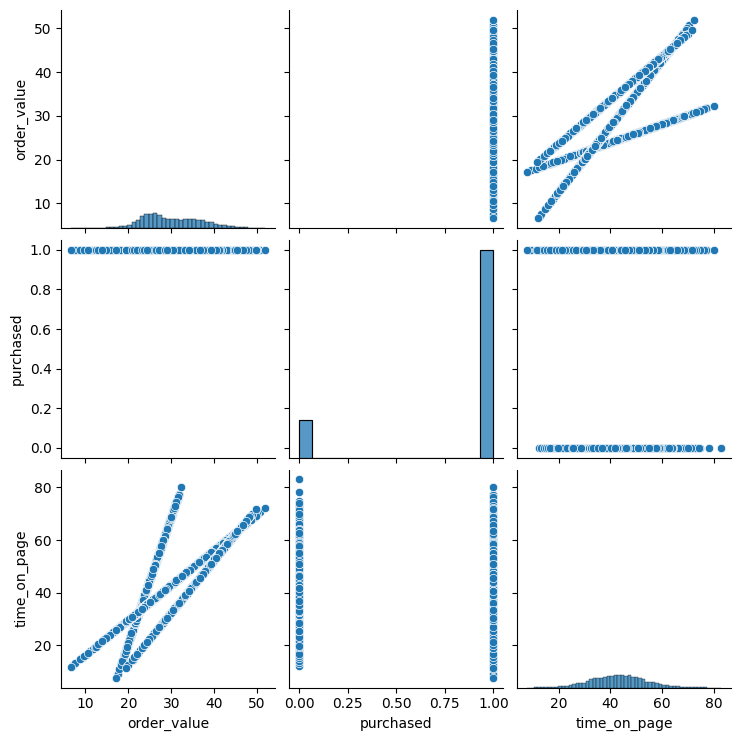

In [ ]:
sns.pairplot(checkout[['order_value', 'purchased',	'time_on_page']])

In [ ]:
checkout[['order_value', 'purchased',	'time_on_page']].corr()

,order_value,purchased,time_on_page
order_value,1.000000,NaN,0.647366
purchased,NaN,1.000000,0.020452
time_on_page,0.647366,0.020452,1.000000




---



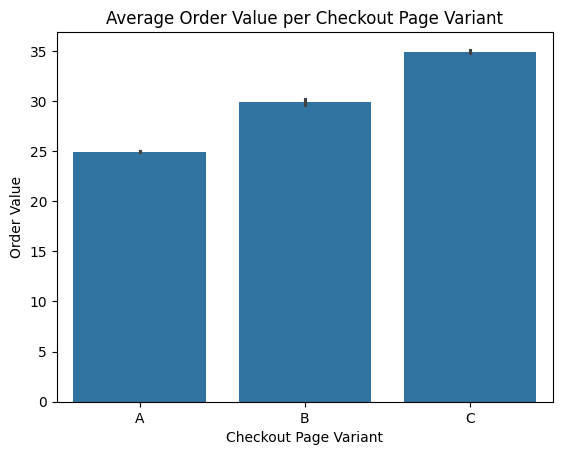

In [ ]:
sns.barplot(x=checkout['checkout_page'], y=checkout['order_value'], estimator=np.mean)
plt.title('Average Order Value per Checkout Page Variant')
plt.xlabel('Checkout Page Variant')
plt.ylabel('Order Value')
plt.show()



---



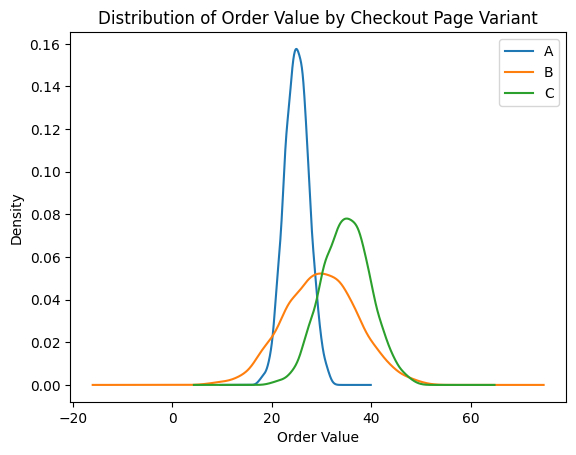

In [ ]:
checkout.groupby('checkout_page')['order_value'].plot(kind='kde') # Remove hue argument as it is not supported by matplotlib
plt.title('Distribution of Order Value by Checkout Page Variant')
plt.xlabel('Order Value')
plt.ylabel('Density')
plt.legend() # Add a legend to differentiate the checkout pages
plt.show()



---



DISTRIBUTION OF TIME SPENT ON EACH PAGE

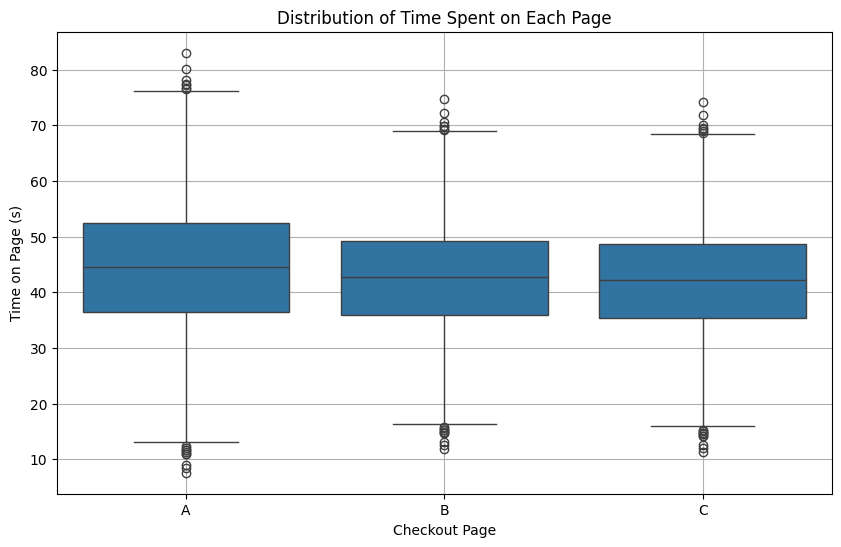

In [ ]:
# Create boxplot with labels and grid
plt.figure(figsize=(10,6))
sns.boxplot(x='checkout_page', y='time_on_page', data=checkout)
plt.title('Distribution of Time Spent on Each Page')
plt.xlabel('Checkout Page')
plt.ylabel('Time on Page (s)')
plt.grid(True)
plt.show()



---



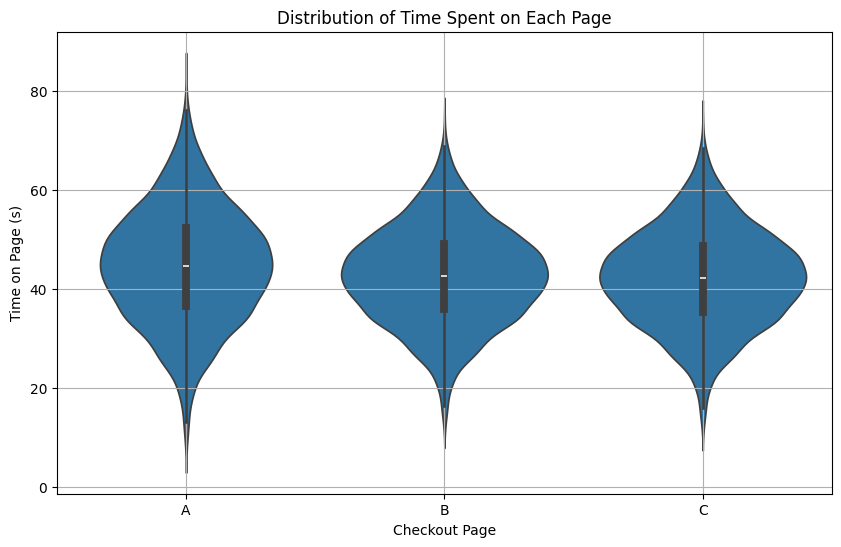

In [ ]:
# Create violin plot with labels and grid
plt.figure(figsize=(10,6))
sns.violinplot(x='checkout_page', y='time_on_page', data=checkout)
plt.title('Distribution of Time Spent on Each Page')
plt.xlabel('Checkout Page')
plt.ylabel('Time on Page (s)')
plt.grid(True)
plt.show()



---



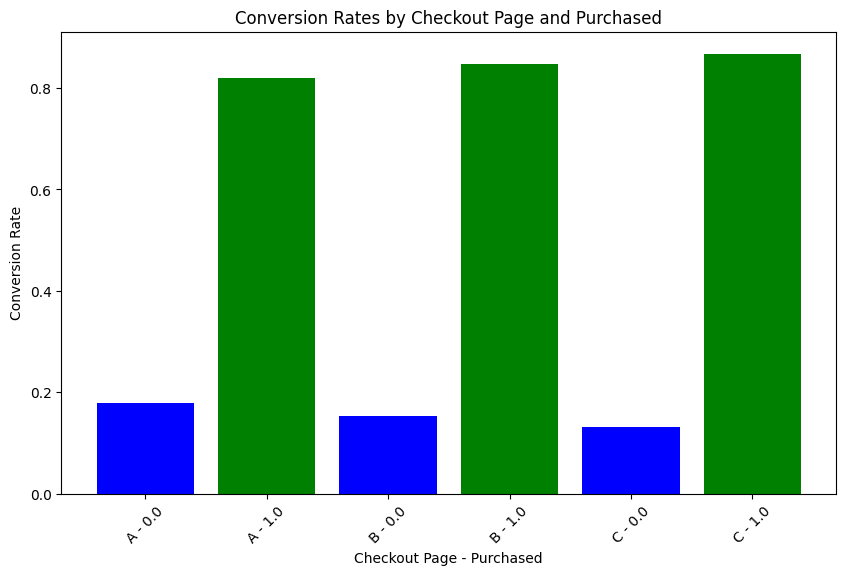

In [ ]:
# Create a list of colors based on the 'purchased' column
colors = ['green' if purchased else 'blue' for purchased in conversion_rates['purchased']]

# Create the figure and plot
plt.figure(figsize=(10, 6))
plt.bar(conversion_rates['checkout_page'] + ' - ' + conversion_rates['purchased'].astype(str),
        conversion_rates['conversion_rate'],
        color=colors)  # Here we use the colors list

# Set labels and title
plt.xlabel('Checkout Page - Purchased')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Checkout Page and Purchased')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()



---



# STATISTICAL ANALYSIS

SHOWING CONVERSION RATES CHECKOUT_PAGE VS PURCHASED

In [ ]:
# Conversion Rates FOR checkout_page and purchased
conversion_rates = checkout.groupby(['checkout_page', 'purchased']).size().div(
    checkout.groupby('checkout_page').size()
).reset_index(name='conversion_rate')

print(conversion_rates)

  checkout_page  purchased  conversion_rate
0             A        0.0         0.179667
1             A        1.0         0.820333
2             B        0.0         0.153000
3             B        1.0         0.847000
4             C        0.0         0.132333
5             C        1.0         0.867667


In [ ]:
n_A = checkout[checkout['checkout_page'] == 'A']['purchased'].count()
n_B = checkout[checkout['checkout_page'] == 'B']['purchased'].count()
n_C = checkout[checkout['checkout_page'] == 'C']['purchased'].count()
print('Group A users: ', n_A)
print('Group B users: ', n_B)
print('Group C users: ', n_C)

Group A users:  3000
Group B users:  3000
Group C users:  3000


In [ ]:
p_A = checkout[checkout['checkout_page'] == 'A']['purchased'].mean()
p_B = checkout[checkout['checkout_page'] == 'B']['purchased'].mean()
p_C = checkout[checkout['checkout_page'] == 'C']['purchased'].mean()
print("Group A mean purchase rate: ", round(p_A,3))
print("Group B mean purchase rate: ", p_B)
print("Group C mean purchase rate: ", round(p_C,3))

Group A mean purchase rate:  0.82
Group B mean purchase rate:  0.847
Group C mean purchase rate:  0.868


PROBABILITY DENSITY FUNCTIONS OF PURCHASED PROPORTIONS FOR CHECKOUTS

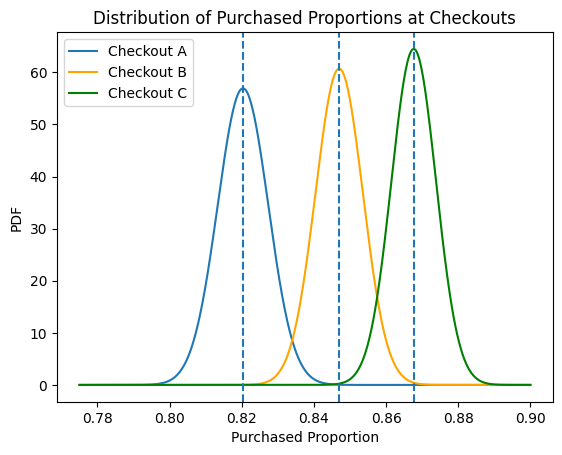

In [ ]:
# Crear rango en eje x
x = np.linspace(0.775, 0.9, 500)
norm_a = norm.pdf(x, p_A, np.sqrt(p_A*(1-p_A) / n_A))
norm_b = norm.pdf(x, p_B, np.sqrt(p_B*(1-p_B) / n_B))
norm_c = norm.pdf(x, p_C, np.sqrt(p_C*(1-p_C) / n_C))
# Plot normal distribution
fig, ax = plt.subplots()
sns.lineplot(x=x, y=norm_a, ax=ax, label='Checkout A')
sns.lineplot(x=x, y=norm_b, color='orange', ax=ax, label='Checkout B')
sns.lineplot(x=x, y=norm_c, color='green', ax=ax, label='Checkout C')
ax.axvline(p_A, linestyle='--')
ax.axvline(p_B, linestyle='--')
ax.axvline(p_C, linestyle='--')
plt.title('Distribution of Purchased Proportions at Checkouts')
plt.xlabel('Purchased Proportion')
plt.ylabel('PDF')
plt.legend(loc="upper left")
plt.show()



---



TEST EFFECT SIZE FOR 3 GROUPS

In [ ]:
# Define effect size, alpha, and power
effect_size = 0.8  # Example effect size (Cohen's h)
alpha = 0.05
power_desired = 0.95

# Calculate required sample size for each group
required_sample_size = power.tt_ind_solve_power(effect_size=effect_size,
                                                   power=power_desired,
                                                   alpha=alpha,
                                                   nobs1=None)

# Available sample size per group
available_sample_size = 9000 / 3

# Check if the available sample size is sufficient
if available_sample_size >= required_sample_size:
    print("The available sample size fulfills the desired effect size.")
else:
    print("The available sample size is insufficient for the desired effect size.")

The available sample size fulfills the desired effect size.


In [ ]:
mean_A = checkout[checkout['checkout_page'] == 'A']['order_value'].mean()
print(mean_A)
mean_B = checkout[checkout['checkout_page'] == 'B']['order_value'].mean()
print(mean_B)
mean_C = checkout[checkout['checkout_page'] == 'C']['order_value'].mean()
print(mean_C)

24.95643704349289
29.876202331571395
34.917588990205545


In [ ]:
std_A = checkout[checkout['checkout_page'] == 'A']['order_value'].std()
print(std_A)
std_B = checkout[checkout['checkout_page'] == 'B']['order_value'].std()
print(std_B)
std_C = checkout[checkout['checkout_page'] == 'C']['order_value'].std()
print(std_C)

2.418836768813335
7.277644184694833
4.869816187984871


CORROBORATING THE DESIRED POWER

In [ ]:
# Set the parameters
alpha = 0.05
sample_size = 3000
group_means = [24.95643704349289, 29.876202331571395, 34.917588990205545]
group_std_devs = [2.4188, 7.2776, 4.8698]
num_simulations = 10000  # Number of simulations to estimate power
num_groups = len(group_means)

# Function to run one simulation of the experiment
def simulate_experiment():
    samples = []
    for i in range(num_groups):
        samples.append(np.random.normal(group_means[i], group_std_devs[i], sample_size))
    f_stat, p_value = stats.f_oneway(*samples)
    return p_value < alpha

# Run the simulations
num_rejections = sum(simulate_experiment() for _ in range(num_simulations))

# Estimate the power
power_estimate = num_rejections / num_simulations
print(f"Estimated power: {power_estimate}")

Estimated power: 1.0


SHOWING PROPORTIONS FOR 3 GROUPS AND DETECTING SAMPLE RATIO MISMATCH

In [ ]:
# Count unique users per checkout_page
unique_users_by_page = checkout.groupby('checkout_page')['user_id'].nunique()

control_users = unique_users_by_page.get('A', 0)
exposed_users1 = unique_users_by_page.get('B', 0)
exposed_users2 = unique_users_by_page.get('C', 0)

total_users = control_users + exposed_users1 + exposed_users2

control_perc = control_users / total_users
exposed_perc_B = exposed_users1 / total_users
exposed_perc_C = exposed_users2 / total_users

print(f"Percentage of users in the Control group: {control_perc:.2%}")
print(f"Percentage of users in the Exposed group B: {exposed_perc_B:.2%}")
print(f"Percentage of users in the Exposed group C: {exposed_perc_C:.2%}")

# Observed user counts
observed = [control_users, exposed_users1, exposed_users2]

# Expected user counts assuming equal distribution
expected_total_users = np.sum(observed)
expected_users_per_group = expected_total_users / len(observed)
expected = [expected_users_per_group] * len(observed)

# Chi-square test
chi = chisquare(observed, f_exp=expected)
print(chi)

if chi.pvalue < 0.01:
    print("SRM may be present")
else:
    print("SRM likely not present")

# Calculate proportions of `order_value` for each `checkout_page`
proportions = checkout.groupby('checkout_page')['order_value'].value_counts(normalize=True)

# Convert to DataFrame for better readability (optional)
proportions_df = proportions.rename('proportion').reset_index()

#print(proportions_df)

Percentage of users in the Control group: 33.29%
Percentage of users in the Exposed group B: 33.27%
Percentage of users in the Exposed group C: 33.45%
Power_divergenceResult(statistic=0.051630434782608696, pvalue=0.9745151464235225)
SRM likely not present


COMPARING GROUP DIFFERENCES: COHEN'S D EFFECT SIZES

In [ ]:
# Calculate means and standard deviations for each group
means = checkout.groupby('checkout_page')['time_on_page'].mean()
stds = checkout.groupby('checkout_page')['time_on_page'].std()
ns = checkout.groupby('checkout_page')['time_on_page'].count()

# Extracting values
mean_A, mean_B, mean_C = means['A'], means['B'], means['C']
std_A, std_B, std_C = stds['A'], stds['B'], stds['C']
n_A, n_B, n_C = ns['A'], ns['B'], ns['C']

# Function to calculate Cohen's d
def calculate_cohens_d(mean1, mean2, std1, std2, n1, n2):
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    cohen_d = (mean1 - mean2) / pooled_std
    return cohen_d

# Calculate Cohen's d for each pair of groups
d_AB = calculate_cohens_d(mean_A, mean_B, std_A, std_B, n_A, n_B)
d_AC = calculate_cohens_d(mean_A, mean_C, std_A, std_C, n_A, n_C)
d_BC = calculate_cohens_d(mean_B, mean_C, std_B, std_C, n_B, n_C)

print(f"Cohen's d for A vs B: {d_AB:.3f}")
print(f"Cohen's d for A vs C: {d_AC:.3f}")
print(f"Cohen's d for B vs C: {d_BC:.3f}")

Cohen's d for A vs B: 0.181
Cohen's d for A vs C: 0.228
Cohen's d for B vs C: 0.052


**OBSERVATIONS:**

Comparing the values, we can see that the difference in time spent on page A compared to page C (d = 0.228) is larger than the difference between page A and page B (d = 0.181)

A has a small impact on C, effect size of 0.228 means that for every standard deviation unit change in the variable C, the variable A changes by approximately 0.23 standard deviation units

The effect of page A on time spent is more pronounced when compared to page C.

In conclusion, the time spent on page A has a greater effect size on the time spent on page C than on page B

# A/B TEST ANALYSIS

## TESTING FOR DIFFERENCES IN PURCHASE PROBABILITY ACROSS CHECKOUT PAGES: PAIRWISE ANALYSIS

In [ ]:
pairwise = pingouin.pairwise_tests(data=checkout,
                                   dv='purchased',
                                   between='checkout_page',
                                   padjust='bonf')
print(pairwise)

        Contrast  A  B  Paired  Parametric         T     dof alternative  \
0  checkout_page  A  B   False        True -2.774819  5998.0   two-sided   
1  checkout_page  A  C   False        True -5.062121  5998.0   two-sided   
2  checkout_page  B  C   False        True -2.289271  5998.0   two-sided   

          p-unc    p-corr p-adjust       BF10    hedges  
0  5.540341e-03  0.016621     bonf      1.351 -0.071637  
1  4.269844e-07  0.000001     bonf  1.007e+04 -0.130687  
2  2.209820e-02  0.066295     bonf      0.397 -0.059101  


**OBSERVATIONS:**

We reject the null hypothesis for both comparisons (A vs B and A vs C), indicating that there are statistically significant differences in the purchase rates

As for (B vs C) we fail to reject the null hypothesis, suggesting there is no statistically significant difference in the purchase rate between these two checkout pages at the 5% significance level

Checkout Page C seems to perform better than both Checkout Page A and Checkout Page B in terms of purchase rates, we should focus on Page C

## TESTING FOR DIFFERENCES IN CHECKOUT PAGE TIME: PAIRWISE ANALYSIS

In [ ]:
pairwise = pingouin.pairwise_tests(data=checkout,
                                   dv='time_on_page',
                                   between='checkout_page',
                                   padjust='bonf')
print(pairwise)

        Contrast  A  B  Paired  Parametric         T     dof alternative  \
0  checkout_page  A  B   False        True  7.026673  5998.0   two-sided   
1  checkout_page  A  C   False        True  8.833244  5998.0   two-sided   
2  checkout_page  B  C   False        True  1.995423  5998.0   two-sided   

          p-unc        p-corr p-adjust       BF10    hedges  
0  2.349604e-12  7.048812e-12     bonf  1.305e+09  0.181405  
1  1.316118e-18  3.948354e-18     bonf  1.811e+15  0.228045  
2  4.604195e-02  1.381258e-01     bonf      0.212  0.051515  


**OBSERVATIONS:**

Page A might be more confusing, or more engaging, or requires more interaction from users, and because of that people spend more time on page A

It might be possible that page C is more user-friendly than page B and because of that people spend less time on page C